In [27]:
import pandas as pd
import ast
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import matplotlib.pyplot as plt
from nltk.stem.porter import *
import numpy as np
import nltk
np.random.seed(2018)
nltk.download('wordnet')
import json

MORE_STOP_WORDS = frozenset({'birdwatch', 'lives', 'people', 'live', 'give','believe', 'contribute', 'belief', 'https','satire', 'clear', 'real', 'post', 'tweets','posted', 'posting','take','claim','claiming','claimed', 'inform', 'better', 'live','informing', 'informed','like', 'quote', 'note', 'article', 'news', 'html', 'faq', 'quoting', 'quotation', 'need', 'quot', 'quoted', 'quoting', 'claim', 'fact', 'check', 'context', 'factcheck', 'claimed', 'claiming', 'false', 'content', 'actual', 'include', 'including', 'say', 'change', 'know', 'knowing', 'source', 'sourced', 'sourcing', 'opinion', 'misleading', 'cause', 'question', 'media', 'give', 'require', 'sourc', 'question', 'effect', 'tweet', 'photo', 'evidence', 'image', 'twitter', 'status', 'account', 'effects', 'say', 'says','factual', 'true', 'author', 'user', 'tweeted', 'faq ', 'wikipedia', 'wiki', 'video', 'say', 'report', 'posting', 'post', 'origin', 'report', 'cause', 'causing', 'claim', 'post', 'link', 'fake', 'statement', 'data', 'group', 'state', 'social', 'inform'})

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/NiharikaBhaskar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [43]:
tweet_topics = pd.read_csv("tweet_topics.csv")

In [82]:
# load into dataframe
all_tweet = []
with open('all_tweet_data.json', 'rt') as f:
    for line in f:
        all_tweet.append(ast.literal_eval(line))
df = pd.DataFrame(all_tweet)

In [83]:
df['data'][0]["text"]

'...and my father has even been wearing a wire at the FBI’s direction to catch these criminals. The planted leak to the FBI tonight was intended to thwart that investigation.\n\nNo part of the allegations against me are true, and the people pushing these lies are targets...'

In [84]:
df['data'][0]["created_at"]

'2021-03-30T22:50:24.000Z'

In [85]:
df['tweet_text'] = df['data'].apply(lambda x: x['text'] if isinstance(x, dict) and 'text' in x else None)
df['tweet_date'] = df['data'].apply(lambda x: x['created_at'] if isinstance(x, dict) and 'text' in x else None)

In [87]:
df = df.loc[df['cn_classification'] != 'NOT_MISLEADING']

In [91]:
df.columns

Index(['data', 'cn_noteId', 'cn_noteAuthorParticipantId', 'cn_createdAtMillis',
       'cn_tweetId', 'cn_classification', 'cn_believable', 'cn_harmful',
       'cn_validationDifficulty', 'cn_misleadingOther',
       'cn_misleadingFactualError', 'cn_misleadingManipulatedMedia',
       'cn_misleadingOutdatedInformation',
       'cn_misleadingMissingImportantContext',
       'cn_misleadingUnverifiedClaimAsFact', 'cn_misleadingSatire',
       'cn_notMisleadingOther', 'cn_notMisleadingFactuallyCorrect',
       'cn_notMisleadingOutdatedButNotWhenWritten',
       'cn_notMisleadingClearlySatire', 'cn_notMisleadingPersonalOpinion',
       'cn_trustworthySources', 'cn_summary', 'errors', 'tweet_text',
       'tweet_date'],
      dtype='object')

In [92]:
# get relevant columns
tweets = df[['tweet_text','tweet_date']]
tweets['index'] = tweets.index

/var/folders/yq/hk50b_d51pq3f36jlcgmf_fw0000gn/T/ipykernel_56637/337835960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['index'] = tweets.index


In [99]:
# Drop elements with NaN values in column 
tweets = tweets.dropna(subset=['tweet_text'])

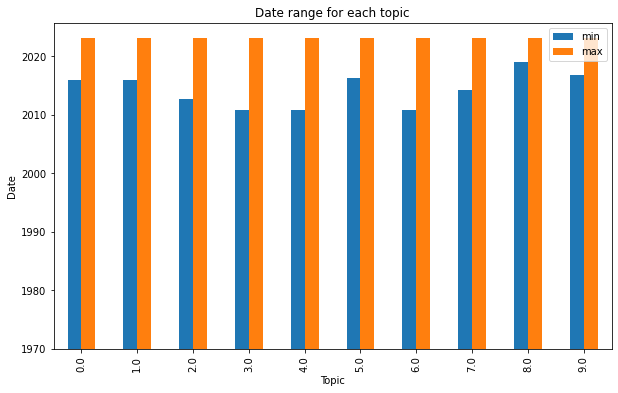

In [49]:
# Convert tweet_time column to datetime format
tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])

# Group the dataframe by Dominant_Topic and aggregate the tweet_time column to get the minimum and maximum dates for each topic
topic_dates = tweet_topics.groupby("Dominant_Topic")["tweet_time"].agg(["min", "max"])

# Create a bar chart with the range of dates for each topic
topic_dates.plot(kind="bar", figsize=(10, 6))

# Add labels and a title
plt.title("Date range for each topic")
plt.xlabel("Topic")
plt.ylabel("Date")

# Show the chart
plt.show()

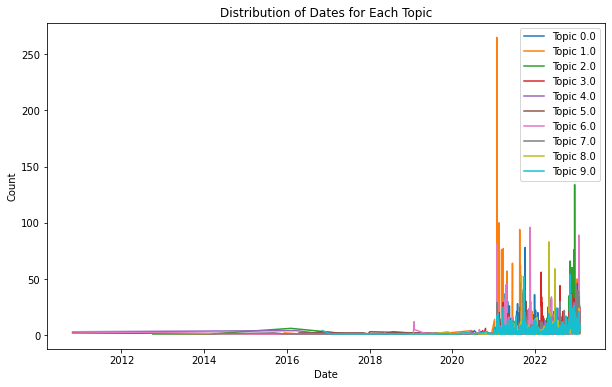

In [127]:
# Drop rows with NaT values
tweet_topics = tweet_topics.dropna(subset=['tweet_time'])

# Group by topic and date
grouped = tweet_topics.groupby(['Dominant_Topic', pd.Grouper(key='tweet_time', freq='D')]).size().reset_index(name='count')

# Plot graph
fig, ax = plt.subplots(figsize=(10,6))
for topic, data in grouped.groupby('Dominant_Topic'):
    ax.plot(data['tweet_time'], data['count'], label=f"Topic {topic}")
ax.legend()
ax.set_title('Distribution of Dates for Each Topic')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.show()

/var/folders/yq/hk50b_d51pq3f36jlcgmf_fw0000gn/T/ipykernel_56637/1648719739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])
/var/folders/yq/hk50b_d51pq3f36jlcgmf_fw0000gn/T/ipykernel_56637/1648719739.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_time'] = df['tweet_time'].apply(lambda x: x.strftime('%Y-%m-%d'))
/var/folders/yq/hk50b_d51pq3f36jlcgmf_fw0000gn/T/ipykernel_56637/1648719739.py:13: SettingWithCopyWarning: 

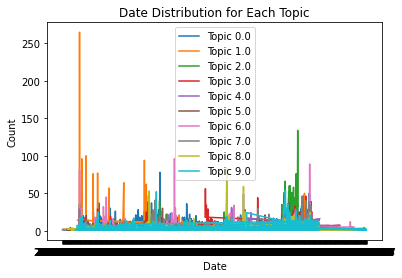

In [129]:
# Convert tweet_time column to datetime format
tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])

# Group by Dominant_Topic and tweet_time, count the number of occurrences
grouped = tweet_topics.groupby(['Dominant_Topic', pd.Grouper(key='tweet_time', freq='D')]).size().reset_index(name='count')

# Loop through each topic and plot the date distribution
for topic in grouped['Dominant_Topic'].unique():
    # Subset the dataframe for a specific topic
    df = grouped[grouped['Dominant_Topic'] == topic]
    
    # Convert date to string format for plotting
    df['tweet_time'] = df['tweet_time'].apply(lambda x: x.strftime('%Y-%m-%d'))
    
    # Plot the date distribution for the topic
    plt.plot(df['tweet_time'], df['count'], label='Topic ' + str(topic))
    
# Add plot labels and legend
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Date Distribution for Each Topic')
plt.legend()
plt.show()


/var/folders/yq/hk50b_d51pq3f36jlcgmf_fw0000gn/T/ipykernel_56637/4135319271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_topics['year_month'] = tweet_topics['tweet_time'].apply(lambda x: x.strftime('%Y-%m'))


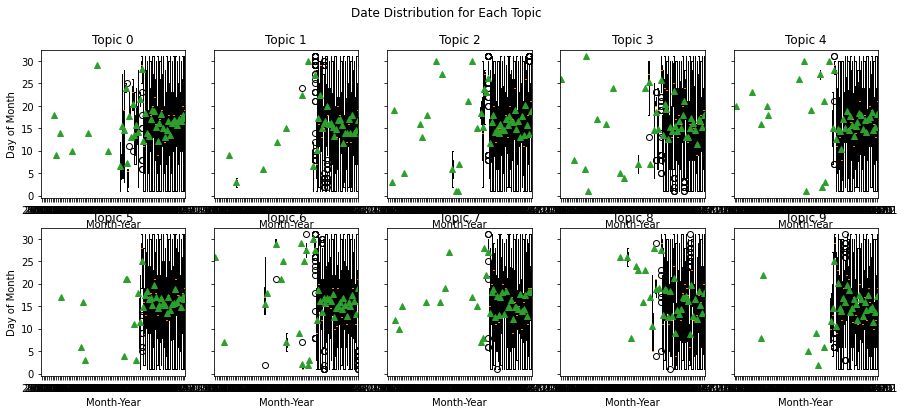

In [131]:
# Extract the year and month from tweet_time column
tweet_topics['year_month'] = tweet_topics['tweet_time'].apply(lambda x: x.strftime('%Y-%m'))

# Create a list of unique year-month combinations to use as x-axis ticks
year_months = sorted(tweet_topics['year_month'].unique())

# Create a list of topic labels
topics = ['Topic ' + str(i) for i in range(10)]

# Create a subplot for each topic
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), sharey=True)
axes = axes.flatten()

# Loop through each topic and plot the date distribution
for i, topic in enumerate(topics):
    # Subset the dataframe for a specific topic
    df = tweet_topics[tweet_topics['Dominant_Topic'] == i]
    
    # Extract the year-month for each tweet and create a list of lists to pass to boxplot
    data = []
    for year_month in year_months:
        data.append(list(df[df['year_month'] == year_month]['tweet_time'].dt.day))
    
    # Plot the box and whisker plot for the topic
    axes[i].boxplot(data, labels=year_months, showmeans=True)
    axes[i].set_title(topic)
    axes[i].set_xlabel('Month-Year')
    if i == 0 or i == 5:
        axes[i].set_ylabel('Day of Month')
    
# Add plot labels and title
fig.suptitle('Date Distribution for Each Topic')
plt.show()

In [154]:
# convert tweet_time to datetime format
tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])

# group by dominant_topic and tweet_time, and count the number of tweets
grouped = tweet_topics.groupby(['Dominant_Topic', pd.Grouper(key='tweet_time', freq='M')]).size().reset_index(name='count')

# sort by count in descending order
sorted_grouped = grouped.sort_values(['Dominant_Topic', 'count'], ascending=[True, False])

# extract the dates with the highest count for each topic
top_dates = []
for i in range(10):
    data = sorted_grouped[sorted_grouped['Dominant_Topic'] == i]
    top_date = data.iloc[0]['tweet_time']
    top_dates.append(top_date)


/var/folders/yq/hk50b_d51pq3f36jlcgmf_fw0000gn/T/ipykernel_56637/1292273988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])


In [156]:
top_dates

[Timestamp('2023-01-31 00:00:00+0000', tz='UTC'),
 Timestamp('2023-01-31 00:00:00+0000', tz='UTC'),
 Timestamp('2022-12-31 00:00:00+0000', tz='UTC'),
 Timestamp('2023-01-31 00:00:00+0000', tz='UTC'),
 Timestamp('2022-05-31 00:00:00+0000', tz='UTC'),
 Timestamp('2023-01-31 00:00:00+0000', tz='UTC'),
 Timestamp('2023-01-31 00:00:00+0000', tz='UTC'),
 Timestamp('2023-01-31 00:00:00+0000', tz='UTC'),
 Timestamp('2023-01-31 00:00:00+0000', tz='UTC'),
 Timestamp('2022-11-30 00:00:00+0000', tz='UTC')]

/var/folders/yq/hk50b_d51pq3f36jlcgmf_fw0000gn/T/ipykernel_56637/2137647278.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])


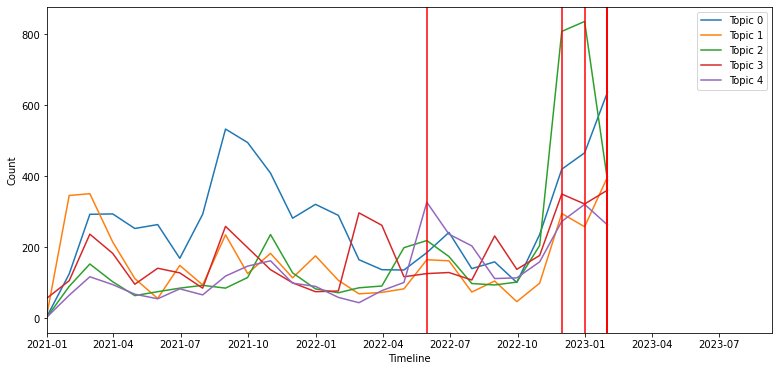

In [155]:
# convert tweet_time to datetime format
tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])

# group by dominant_topic and tweet_time, and count the number of tweets
grouped = tweet_topics.groupby(['Dominant_Topic', pd.Grouper(key='tweet_time', freq='M')]).size().reset_index(name='count')

# plot the data
fig, ax = plt.subplots(figsize=(13, 6))

topics = [0, 1,2, 3, 4]
for i in topics:
    data = grouped[grouped['Dominant_Topic'] == i]
    ax.plot(data['tweet_time'], data['count'], label='Topic {}'.format(i))

# set the axis labels and legend
ax.set_xlabel('Timeline')
ax.set_ylabel('Count')
ax.set_xlim(pd.Timestamp('2021-01-01'))


# add a vertical line for each top date
for date in top_dates:
    ax.axvline(date, color='r')

    
ax.legend()

# show the plot
plt.show()

/var/folders/yq/hk50b_d51pq3f36jlcgmf_fw0000gn/T/ipykernel_56637/1400450248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])


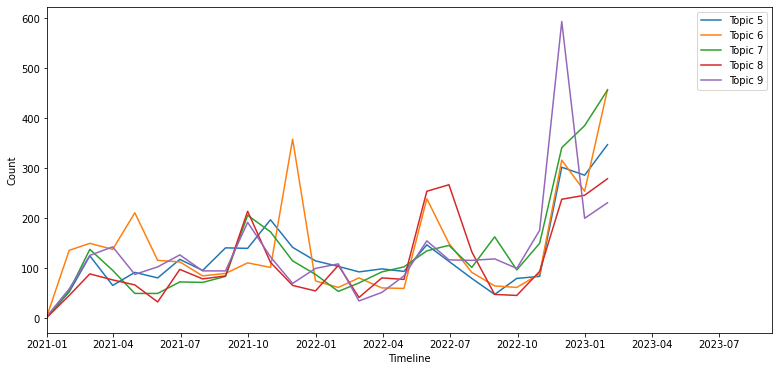

In [271]:
# convert tweet_time to datetime format
tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])

# group by dominant_topic and tweet_time, and count the number of tweets
grouped = tweet_topics.groupby(['Dominant_Topic', pd.Grouper(key='tweet_time', freq='M')]).size().reset_index(name='count')

# plot the data
fig, ax = plt.subplots(figsize=(13, 6))

topics = [5, 6, 7, 8, 9]
for i in topics:
    data = grouped[grouped['Dominant_Topic'] == i]
    ax.plot(data['tweet_time'], data['count'], label='Topic {}'.format(i))

# set the axis labels and legend
ax.set_xlabel('Timeline')
ax.set_ylabel('Count')
ax.set_xlim(pd.Timestamp('2021-01-01'))
ax.legend()

# show the plot
plt.show()

In [191]:
# convert tweet_time to datetime format
tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])

# group by dominant_topic and tweet_time, and count the number of tweets
grouped = tweet_topics.groupby(['Dominant_Topic', pd.Grouper(key='tweet_time', freq='M')]).size().reset_index(name='count')

# sort by count in descending order
sorted_grouped = grouped.sort_values(['Dominant_Topic', 'count'], ascending=[True, False])

# extract the dates with the highest count for each topic
top_dates = {}
for i in range(10):
    data = sorted_grouped[sorted_grouped['Dominant_Topic'] == i]
    top_dates[i] = [(data.iloc[0]['tweet_time'], data.iloc[0]['count'])]
    for j in (1,2,3,4):
        top_dates[i].append( (data.iloc[j]['tweet_time'], data.iloc[j]['count']) )

# define a colormap
colors = cm.tab10.colors

/var/folders/yq/hk50b_d51pq3f36jlcgmf_fw0000gn/T/ipykernel_56637/1528303774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_topics['tweet_time'] = pd.to_datetime(tweet_topics['tweet_time'])


In [192]:
top_dates[0]

[(Timestamp('2023-01-31 00:00:00+0000', tz='UTC'), 637),
 (Timestamp('2021-08-31 00:00:00+0000', tz='UTC'), 533),
 (Timestamp('2021-09-30 00:00:00+0000', tz='UTC'), 495),
 (Timestamp('2022-12-31 00:00:00+0000', tz='UTC'), 466),
 (Timestamp('2022-11-30 00:00:00+0000', tz='UTC'), 420)]

In [196]:
top_dates[1][0][0]

Timestamp('2023-01-31 00:00:00+0000', tz='UTC')

In [211]:
colors

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529))

In [276]:
top_dates[0][1][0]

Timestamp('2021-08-31 00:00:00+0000', tz='UTC')

In [278]:
top_dates[1][1][0]

Timestamp('2021-02-28 00:00:00+0000', tz='UTC')

In [280]:
top_dates[2][0][0]

Timestamp('2022-12-31 00:00:00+0000', tz='UTC')

In [281]:
top_dates[3][1][0]

Timestamp('2022-11-30 00:00:00+0000', tz='UTC')

In [282]:
top_dates[4][0][0]

Timestamp('2022-05-31 00:00:00+0000', tz='UTC')

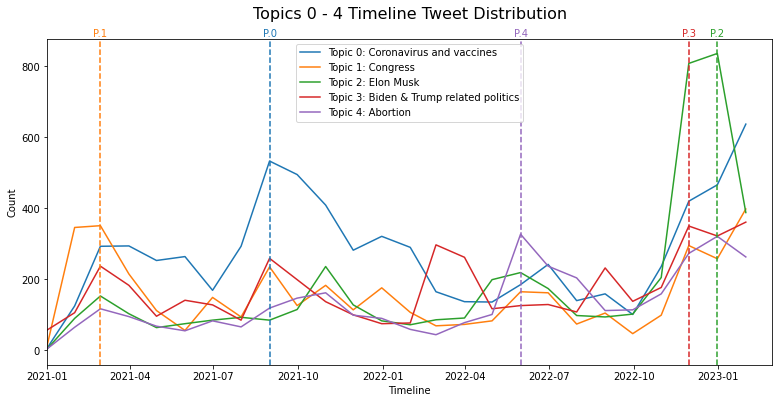

In [272]:
# plot the data
fig, ax = plt.subplots(figsize=(13, 6))

topics = [0, 1, 2, 3, 4]
label = ['Coronavirus and vaccines', 'Congress', 'Elon Musk', 'Biden & Trump related politics', 'Abortion']
for i in topics:
    data = grouped[grouped['Dominant_Topic'] == i]
    ax.plot(data['tweet_time'], data['count'], label='Topic {}'.format(i) + ": " + label[i], color=colors[i])

# set the axis labels and legend
ax.set_xlabel('Timeline')
ax.set_ylabel('Count')
ax.set_xlim(pd.Timestamp('2021-01-01'))
ax.set_xlim(right=pd.Timestamp('2023-03-01'))
ax.set_title("Topics 0 - 4 Timeline Tweet Distribution", fontsize=16,pad=20)
ax.legend()

ax.axvline(top_dates[0][1][0], color=colors[0], linestyle='--')
ax.text(top_dates[0][1][0], ax.get_ylim()[1], "P.0", va='bottom', ha='center', color=colors[0])


ax.axvline(top_dates[1][1][0], color=colors[1], linestyle='--')
ax.text(top_dates[1][1][0], ax.get_ylim()[1], "P.1", va='bottom', ha='center', color=colors[1])

ax.axvline(top_dates[2][0][0], color=colors[2], linestyle='--')
ax.text(top_dates[2][0][0], ax.get_ylim()[1], "P.2", va='bottom', ha='center', color=colors[2])

ax.axvline(top_dates[3][1][0], color=colors[3], linestyle='--')
ax.text(top_dates[3][1][0], ax.get_ylim()[1], "P.3", va='bottom', ha='center', color=colors[3])

ax.axvline(top_dates[4][0][0], color=colors[4], linestyle='--')
ax.text(top_dates[4][0][0], ax.get_ylim()[1], "P.4", va='bottom', ha='center', color=colors[4])


# show the plot
plt.show()

In [283]:
top_dates[5][2][0]

Timestamp('2022-12-31 00:00:00+0000', tz='UTC')

In [284]:
top_dates[6][1][0]

Timestamp('2021-11-30 00:00:00+0000', tz='UTC')

In [285]:
top_dates[7][0][0]

Timestamp('2023-01-31 00:00:00+0000', tz='UTC')

In [286]:
top_dates[8][1][0]

Timestamp('2022-06-30 00:00:00+0000', tz='UTC')

In [287]:
top_dates[9][0][0]

Timestamp('2022-11-30 00:00:00+0000', tz='UTC')

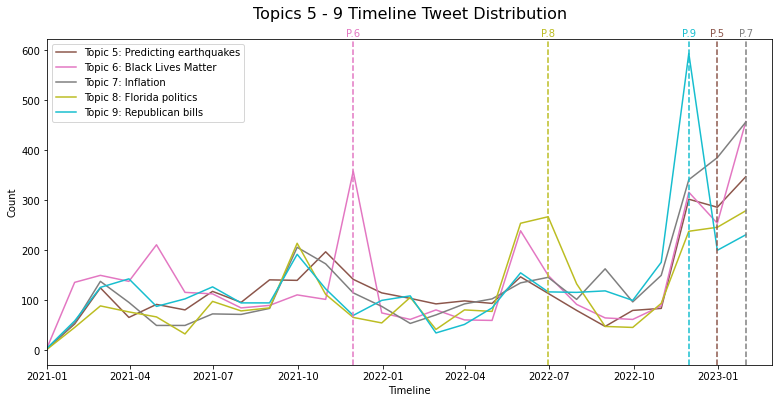

In [289]:
# plot the data
fig, ax = plt.subplots(figsize=(13, 6))

topics = [5, 6, 7, 8, 9]
label = ['Predicting earthquakes', 'Black Lives Matter', 'Inflation', 'Florida politics', 'Republican bills']
for i in topics:
    data = grouped[grouped['Dominant_Topic'] == i]
    ax.plot(data['tweet_time'], data['count'], label='Topic {}'.format(i) + ": " + label[i-5], color=colors[i])

# set the axis labels and legend
ax.set_xlabel('Timeline')
ax.set_ylabel('Count')
ax.set_xlim(pd.Timestamp('2021-01-01'))
ax.set_xlim(right=pd.Timestamp('2023-03-01'))

ax.set_title("Topics 5 - 9 Timeline Tweet Distribution", fontsize=16, pad=20)
ax.legend()

# add the vertical lines and labels
ax.axvline(top_dates[5][2][0], color=colors[5], linestyle='--')
ax.text(top_dates[5][2][0], ax.get_ylim()[1], "P.5", va='bottom', ha='center', color=colors[5])

ax.axvline(top_dates[6][1][0], color=colors[6], linestyle='--')
ax.text(top_dates[6][1][0], ax.get_ylim()[1], "P.6", va='bottom', ha='center', color=colors[6])

ax.axvline(top_dates[7][0][0], color=colors[7], linestyle='--')
ax.text(top_dates[7][0][0], ax.get_ylim()[1], "P.7", va='bottom', ha='center', color=colors[7])

ax.axvline(top_dates[8][1][0], color=colors[8], linestyle='--')
ax.text(top_dates[8][1][0], ax.get_ylim()[1], "P.8", va='bottom', ha='center', color=colors[8])

ax.axvline(top_dates[9][0][0], color=colors[9], linestyle='--')
ax.text(top_dates[9][0][0], ax.get_ylim()[1], "P.9", va='bottom', ha='center', color=colors[9])

# show the plot
plt.show()